In [115]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
data = pd.read_csv('../../reports/scores.csv')

In [117]:
data

,approach,preprocessing,estimator,tuning,score,runtime
0,regression,full,baseline_regressor,NaN,0.000000,NaN
1,regression,full,linear_regression,NaN,0.081094,NaN
2,regression,full,svm_regressor,NaN,0.150474,NaN
3,regression,full,knn_regressor,NaN,0.373191,NaN
4,regression,full,decision_tree_regressor,NaN,0.485047,37.0
5,regression,full,random_forest_regressor,NaN,0.479428,NaN
6,regression,full,lgbm_regressor,NaN,0.307539,NaN
7,regression,full,neural_network_regressor,NaN,0.138741,NaN
8,regression,baseline,decision_tree_regressor,NaN,0.480000,NaN
9,regression,full,decision_tree_regressor,bayes,0.557500,5817.0


In [118]:
def get_data(data, approach, estimator, preprocessing=None, tuning=None):
    conditions = pd.Series(np.repeat(True, len(data)))
    conditions = conditions & (data['approach'] == approach) if approach is not None else conditions
    conditions = conditions & (data['estimator'] == estimator) if estimator is not None else conditions
    conditions = conditions & (data['preprocessing'] == preprocessing) if preprocessing is not None else conditions
    conditions = conditions & (data['tuning'] == tuning) if tuning is not None else conditions
    return data[conditions]

def plot(data, name):
    # Filter data based on unique x or y values
    
    data = data.groupby('category').filter(lambda x: x['approach'].nunique() == len(data['approach'].value_counts()))
    sns.barplot(x=data['approach'], y=data['average_spearman'], hue=data['category'])
    plt.title('performance')
    plt.xlabel('')
    if len(data['approach'].value_counts()) >= 3:
        plt.xticks(rotation=15)
    plt.legend(loc='lower left')
    plt.savefig(name + '_comparison.svg', bbox_inches='tight')
    plt.show()
    
def set_category(data, grouping, categories):
    def append_category(row):
        group = tuple(row[grouping].values[0])
        row['category'] = categories[group]
        return row
    grouped = data.groupby(grouping, dropna=False)
    return grouped.apply(append_category).reset_index(drop=True)

In [120]:
data_regression = get_data(data, 'regression', 'decision_tree_regressor')
data_pointwise_regression = pd.concat([
    get_data(data, 'pointwise_regression', 'random_forest_regressor', 'full'),
    get_data(data, 'pointwise_normalized_regression', 'random_forest_regressor')
])
data_pointwise_classification = get_data(data, 'pointwise_classification', 'decision_tree_classifier')
data_pointwise_ordinal_regression = get_data(data, 'pointwise_ordinal_regression', 'decision_tree_classifier')

without_preprocessing = 'no_preprocessing'
without_normalization = 'no_normalization'
without_tuning = 'no_tuning'
with_tuning = 'tuned'

data_regression = set_category(data_regression, ['preprocessing', 'tuning'], {
    ('baseline', np.nan): without_preprocessing,
    ('full', np.nan): without_tuning,
    ('full', 'bayes'): with_tuning
})
data_pointwise_regression = set_category(data_pointwise_regression, ['approach', 'preprocessing', 'tuning'], {
    ('pointwise_normalized_regression', 'baseline', np.nan): without_preprocessing,
    ('pointwise_regression', 'full', np.nan): without_normalization,
    ('pointwise_normalized_regression', 'full', np.nan): without_tuning,
    ('pointwise_normalized_regression', 'full', 'bayes'): with_tuning
}).replace('pointwise_normalized_regression', 'pointwise_regression')
data_pointwise_classification = set_category(data_pointwise_classification, ['preprocessing', 'tuning'], {
    ('baseline', np.nan): without_preprocessing,
    ('full', np.nan): without_tuning,
    ('full', 'bayes'): with_tuning
})
data_pointwise_ordinal_regression = set_category(data_pointwise_ordinal_regression, ['preprocessing', 'tuning'], {
    ('baseline', np.nan): without_preprocessing,
    ('full', np.nan): without_tuning,
    ('full', 'bayes'): with_tuning
})

data_regression = data_regression.sort_values(by='score').reset_index(drop=True)
data_pointwise_regression = data_pointwise_regression.sort_values(by='score').reset_index(drop=True)
data_pointwise_classification = data_pointwise_classification.sort_values(by='score').reset_index(drop=True)
data_pointwise_ordinal_regression = data_pointwise_ordinal_regression.sort_values(by='score').reset_index(drop=True)

data_regression = data_regression.rename(columns={'score': 'average_spearman'})
data_pointwise_regression = data_pointwise_regression.rename(columns={'score': 'average_spearman'})
data_pointwise_classification = data_pointwise_classification.rename(columns={'score': 'average_spearman'})
data_pointwise_ordinal_regression = data_pointwise_ordinal_regression.rename(columns={'score': 'average_spearman'})

data_categorized = pd.concat([data_regression, data_pointwise_regression, data_pointwise_classification, data_pointwise_ordinal_regression])
display(data_categorized)

,approach,preprocessing,estimator,tuning,average_spearman,runtime,category
0,regression,baseline,decision_tree_regressor,NaN,0.480000,NaN,no_preprocessing
1,regression,full,decision_tree_regressor,NaN,0.485047,37.0,no_tuning
2,regression,full,decision_tree_regressor,bayes,0.557500,5817.0,tuned
0,pointwise_regression,baseline,random_forest_regressor,NaN,0.595700,27.0,no_preprocessing
1,pointwise_regression,full,random_forest_regressor,NaN,0.837800,138.0,no_normalization
2,pointwise_regression,full,random_forest_regressor,NaN,0.873100,148.0,no_tuning
3,pointwise_regression,full,random_forest_regressor,bayes,0.880700,17484.0,tuned
0,pointwise_classification,baseline,decision_tree_classifier,NaN,0.306100,NaN,no_preprocessing
1,pointwise_classification,full,decision_tree_classifier,NaN,0.735300,74.0,no_tuning
2,pointwise_classification,full,decision_tree_classifier,bayes,0.742700,7520.0,tuned


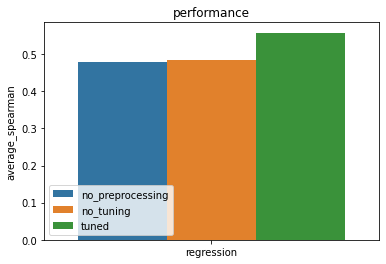

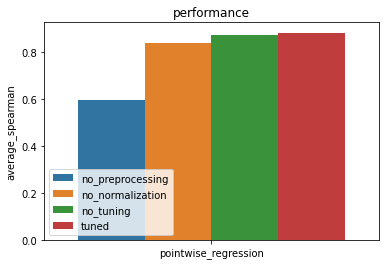

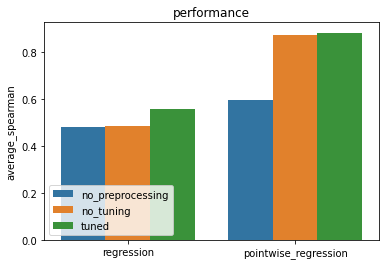

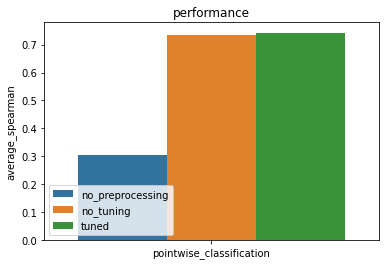

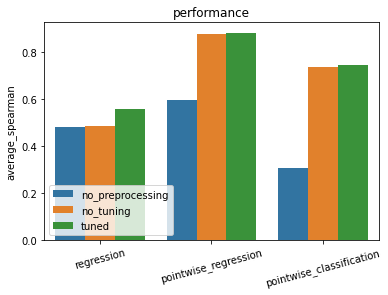

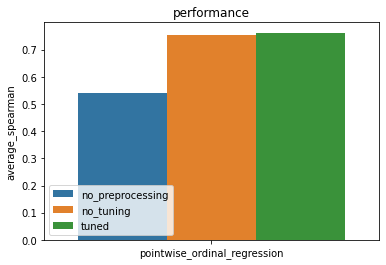

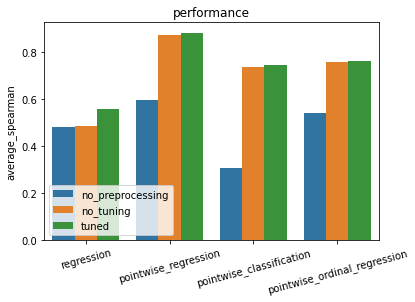

In [121]:
plot(data_regression, 'regression')
plot(data_pointwise_regression, 'pointwise_regression')
plot(pd.concat([data_regression, data_pointwise_regression]), 'regre_ptwregre')
plot(data_pointwise_classification, 'pointwise_classification')
plot(pd.concat([data_regression, data_pointwise_regression, data_pointwise_classification]), 'regre_ptwregre_ptwcls')
plot(data_pointwise_ordinal_regression, 'pointwise_ordinal_regression')
plot(pd.concat([
    data_regression, 
    data_pointwise_regression, 
    data_pointwise_classification,
    data_pointwise_ordinal_regression
]), 'regre_ptwregre_ptwcls_ptword')

C:\Users\Thomas\AppData\Local\Temp/ipykernel_13656/3464372799.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selection['approach'] = data_selection['approach'].map({
C:\Users\Thomas\AppData\Local\Temp/ipykernel_13656/3464372799.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selection['tuning'] = data_selection['tuning'].map({'bayes': 'tuned', np.nan: 'default'})


               approach preprocessing                 estimator   tuning  \
1            regression          full   decision_tree_regressor  default   
2            regression          full   decision_tree_regressor    tuned   
2       ptw. regression          full   random_forest_regressor  default   
3       ptw. regression          full   random_forest_regressor    tuned   
1   ptw. classification          full  decision_tree_classifier  default   
2   ptw. classification          full  decision_tree_classifier    tuned   
1  ptw. ord. regression          full  decision_tree_classifier  default   
2  ptw. ord. regression          full  decision_tree_classifier    tuned   

   average_spearman  runtime   category  
1          0.485047     37.0  no_tuning  
2          0.557500   5817.0      tuned  
2          0.873100    148.0  no_tuning  
3          0.880700  17484.0      tuned  
1          0.735300     74.0  no_tuning  
2          0.742700   7520.0      tuned  
1          0.754400  

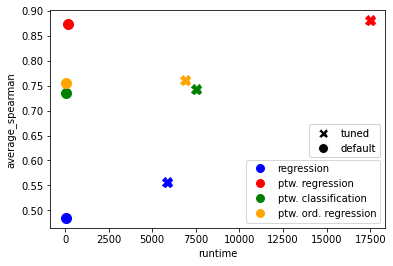

In [152]:
from matplotlib.lines import Line2D

data_selection = data_categorized[data_categorized['category'].isin(['no_tuning', 'tuned'])]
data_selection['approach'] = data_selection['approach'].map({
    'regression': 'regression',
    'pointwise_regression': 'ptw. regression',
    'pointwise_classification': 'ptw. classification',
    'pointwise_ordinal_regression': 'ptw. ord. regression'
})
data_selection['tuning'] = data_selection['tuning'].map({'bayes': 'tuned', np.nan: 'default'})
print(data_selection)

color_map = {
    'regression': 'blue',
    'ptw. regression': 'red',
    'ptw. classification': 'green',
    'ptw. ord. regression': 'orange'
}
marker_map = {
    'tuned': 'X',
    'default': 'o'
}
markersize = 10

fig, ax = plt.subplots()

for index, (approach, preprocessing, estimator, tuning, score, runtime, category) in data_selection.iterrows():
    ax.plot(runtime, score, color=color_map[approach], marker=marker_map[tuning], markersize=markersize)

approach_legend_elements = []
for approach in color_map:
    approach_legend_elements.append(Line2D([0], [0], marker='o', color='w', label=approach, markerfacecolor=color_map[approach], markersize=markersize))

tuning_legend_elements = []
for tuning in marker_map:
    tuning_legend_elements.append(Line2D([0], [0], marker=marker_map[tuning], color='w', label=tuning, markerfacecolor='black', markersize=markersize))

approach_legend = plt.legend(handles=approach_legend_elements, loc='lower right')
tuning_legend = plt.legend(handles=tuning_legend_elements, bbox_to_anchor=(1, 0.5))

plt.gca().add_artist(approach_legend)
plt.gca().add_artist(tuning_legend)

plt.xlabel('runtime')
plt.ylabel('average_spearman')

plt.savefig("runtime_comparison.svg")
plt.show()